# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

This data analysis is looking at a large dataset to understand and advise my customer, a used car dealer, on what sorts of features impact used car prices.

From a data perspective, the task is to develop predictive models to identify and quantify the key factors that influence the prices of used cars. This involves preprocessing and cleaning the data, potentially engineering relevant features, and applying machine learning algorithms to create models that can accurately predict used car prices based on various attributes such as age, mileage, condition, and manufacturer. The goal is to optimize the model's performance through cross-validation and hyperparameter tuning to ensure it generalizes well to unseen data.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.model_selection import train_test_split


In [2]:
# Step 1: Load the dataset
df = pd.read_csv('data/vehicles.csv')

# Step 2: Dataset overview
print("Dataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  obj

## Insights:

Based on the Non-null Count, some columns have many missing values, especially condition, cylinders, drive, size, and VIN.

### From the dataset info:

There are a mix of numerical and categorical data types.

### From the statistical summary:

**id**:
- Seems to be a unique identifier for each entry and not relevant for analysis. Plan to drop.

**price**:
- Range: 0 to 3,736,929,000 (extremely high maximum value and low value of 0, strongly suggesting outliers or more than likely errors)
- Mean: 75,199.03 (probably so high because of the super high data points)
- Median (50th percentile): 13,950 (indicates a right-skewed distribution)

**year**:
- Range: 1900 to 2022 (likely includes vintage cars or could be errors)
- Mean: 2011.24
- Median: 2013

**odometer**:
- Range: 0 to 10,000,000 (another potential for outliers or error - super high and used cars with 0 mileage suspect)
- Mean: 98,043.33 (Again potentially skewed by the large numbers in range)
- Median: 85,548


In [3]:
# Step 3: Column examination
print("\nColumn Names:")
print(df.columns)

# Step 4: Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Step 5: Unique values and cardinality
unique_values = df.nunique()
print("\nUnique Values in Each Column:")
print(unique_values)


Column Names:
Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

Missing Values:
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Unique Values in Each Column:
id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         

## Insights:
### Observations:
- The 'id' column is a unique identifier and not relevant for analysis. It should be dropped.
- Likewise the 'VIN' column is another identifer and not relevant for analysis and many missing values. It should be dropped.
- Columns like 'condition', 'cylinders', 'fuel', 'drive', 'size', 'type', and 'paint_color' have manageable levels of cardinality and missing values and could be important for analysis.
- 'year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission', and 'state' appear to have significant potential for analysis, though some have missing values that need handling.

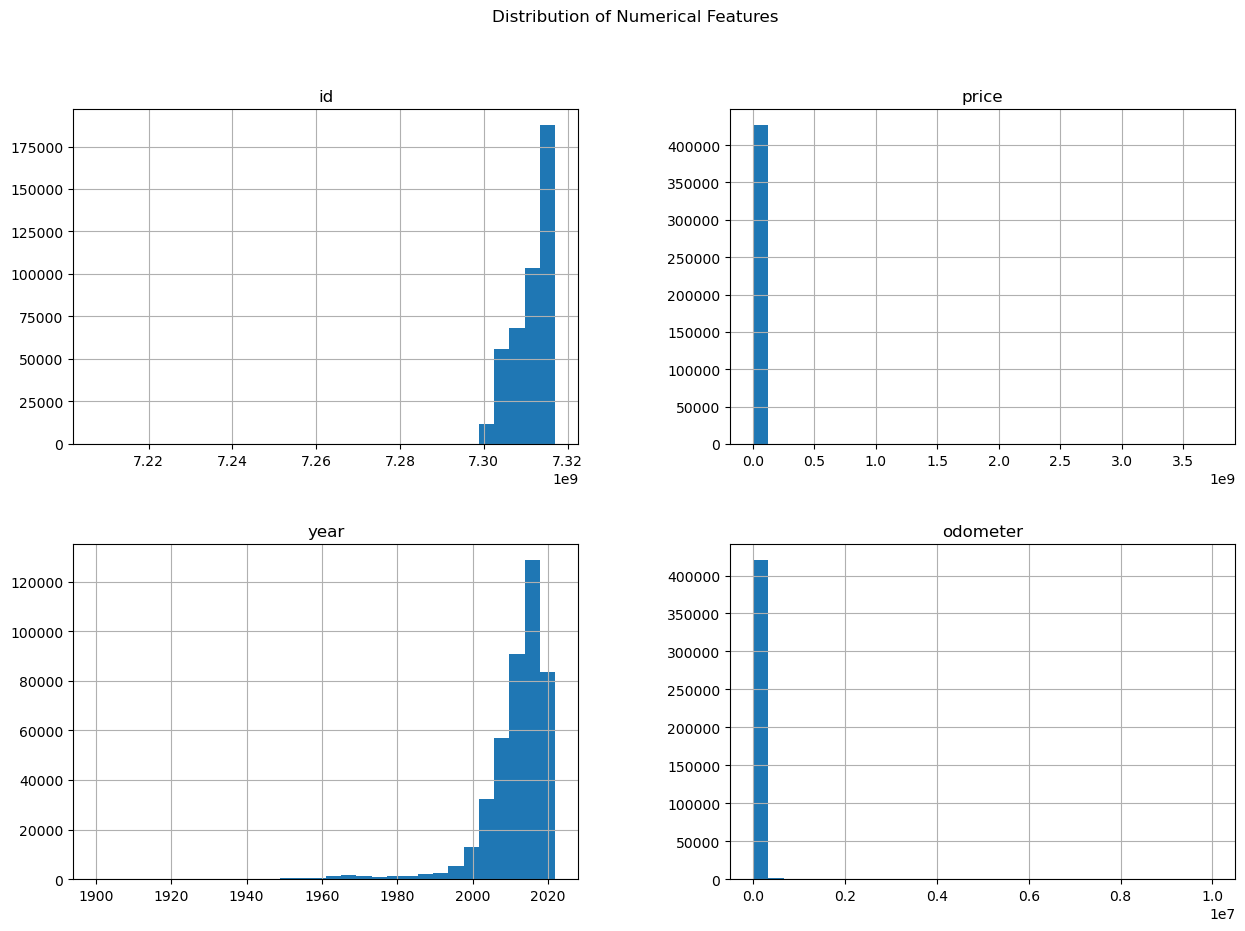

In [4]:
# Step 6: Distribution of numerical features
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

## Insights from the Distribution of Numerical Features:


### Observations:
- **id**:
  - The `id` feature is a unique identifier for each entry.
  - Not relevant for analysis and can be dropped.

- **price**:
  - The `price` feature exhibits a highly right-skewed distribution.
  - There are many low-priced entries, but a few extremely high values indicate potential outliers or errors.
  - Action: Cap outliers for better analysis

- **year**:
  - The `year` feature shows most entries are from the late 1990s to 2022.
  - There are some entries with very old years, potentially indicating vintage cars or data entry errors.
  - Action: Filter out extremely old years
  
- **odometer**:
  - The `odometer` feature also shows a highly right-skewed distribution.
  - Many entries have low odometer readings, but there are some extremely high values, which could be errors.
  - Action: Similar to `price`, cap outliers for better analysis
  

### Next Steps:
1. **Drop the `id` and `vin` columns** since they do not add value to the analysis.
2. **Handle outliers** in the `price` and `odometer` columns to improve the model's performance.
3. **Filter the `year` column** to remove unlikely or irrelevant years (e.g., extremely old years).
4. Continue with further exploratory data analysis and data preparation steps.

                id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000


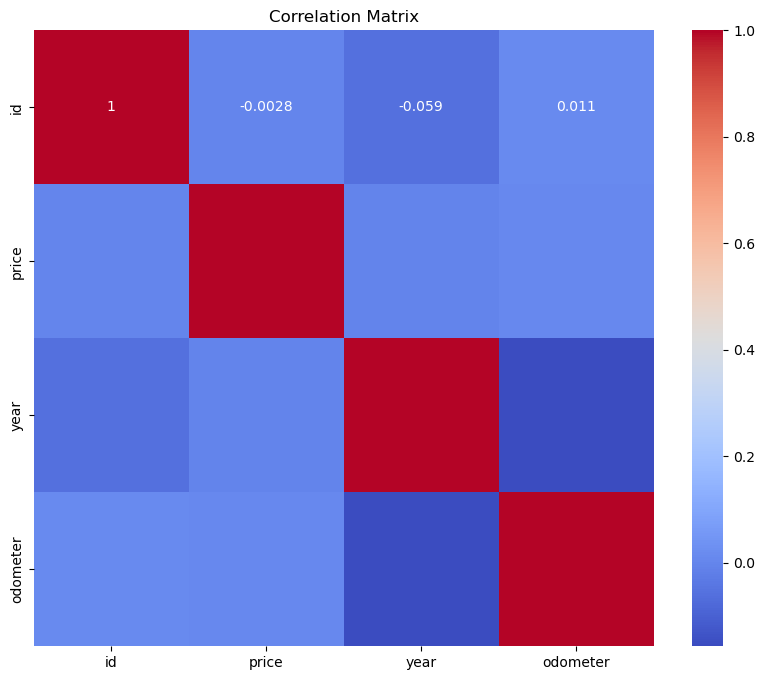

In [5]:
# Step 7: Relationships between variables

# Select the numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Generate the correlation matrix
correlation_matrix = numeric_columns.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Insights from the Correlation Matrix:

- **Price**:
  - Has a very weak negative correlation with `year` (-0.0049), indicating that newer cars do not significantly influence the price in our dataset.
  - Has a very weak positive correlation with `odometer` (0.0100), suggesting that the odometer reading (mileage) does not strongly influence the price.
  
- **Year**:
  - Shows a weak negative correlation with `odometer` (-0.1572), indicating that newer cars tend to have lower mileage, which is intuitive.
  
- **Odometer**:
  - Exhibits a very weak positive correlation with `price` (0.0100), reinforcing the observation that mileage does not significantly impact the price in our dataset.

### Overall Observations:
- The `id` column, being a unique identifier, does not have any meaningful correlation with other variables and should be excluded from the analysis.
- The correlations between `price`, `year`, and `odometer` are very weak, suggesting that other features (likely categorical) may play a more substantial role in determining the price but by eliminating the rows with the hughe outliers and less than $1000 I anticipate this may increase.
- This weak correlation indicates a need for further exploration and inclusion of other variables to build a more predictive model for used car prices.


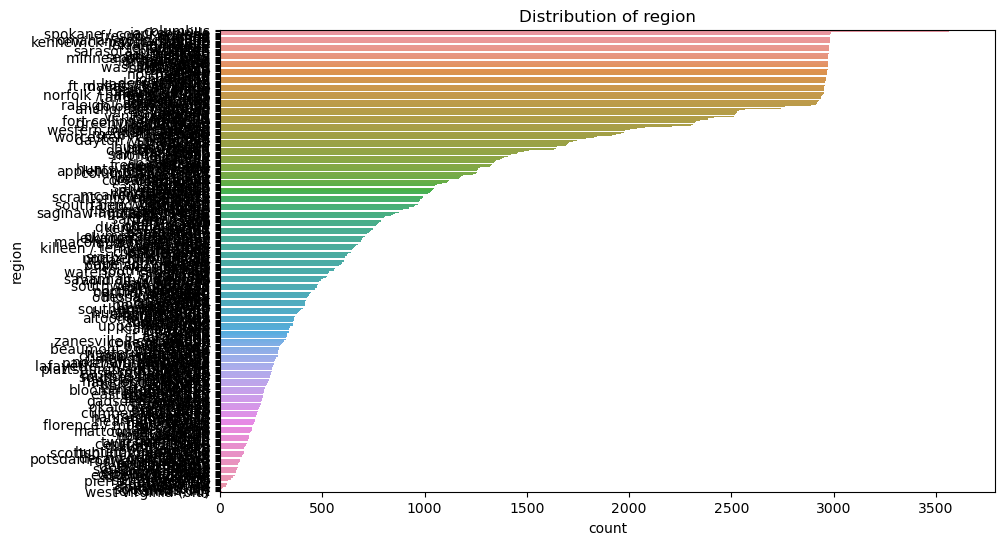

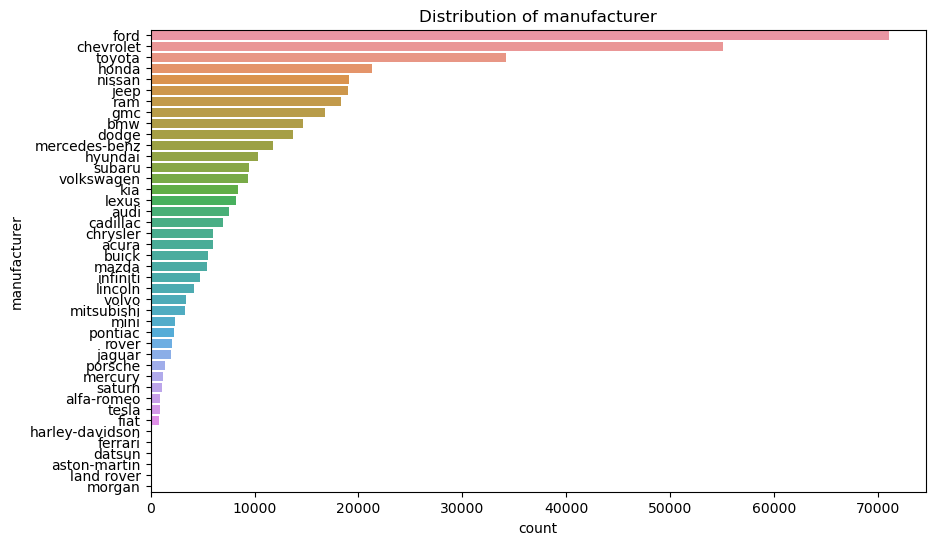

ValueError: 
1500 laramie, $452.02 month, 2.9% apr, $2000 down, 72 m laramie, $452.02 month, 2.9% apr, $2000 down, 72 m
              ^
ParseException: Expected end of text, found '$'  (at char 14), (line:1, col:15)

<Figure size 1000x600 with 1 Axes>

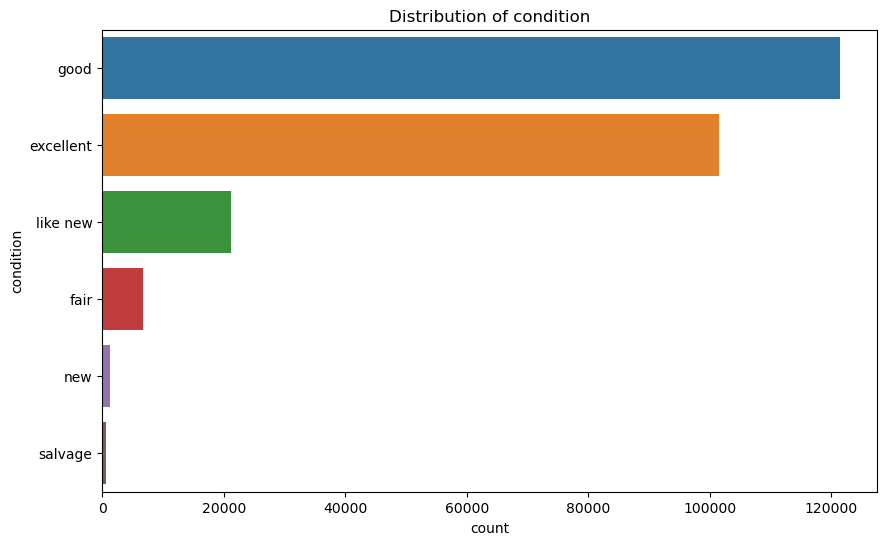

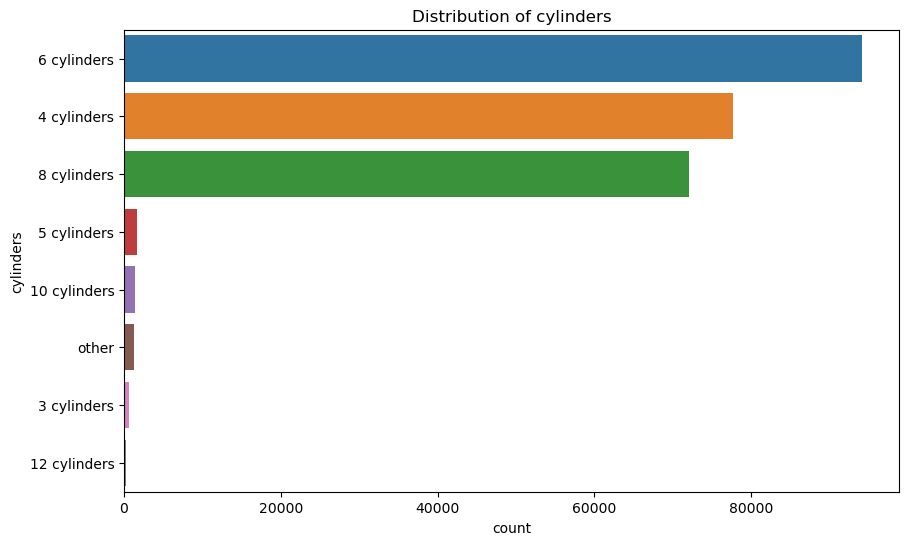

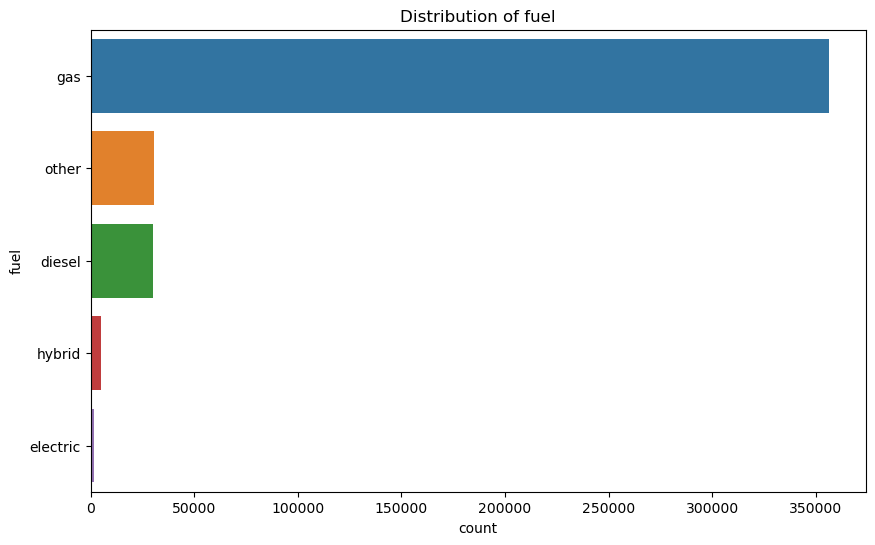

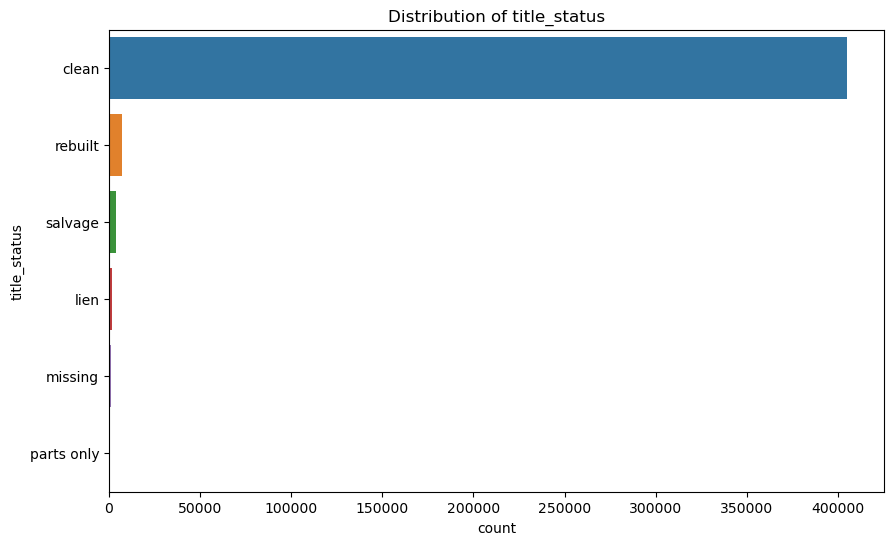

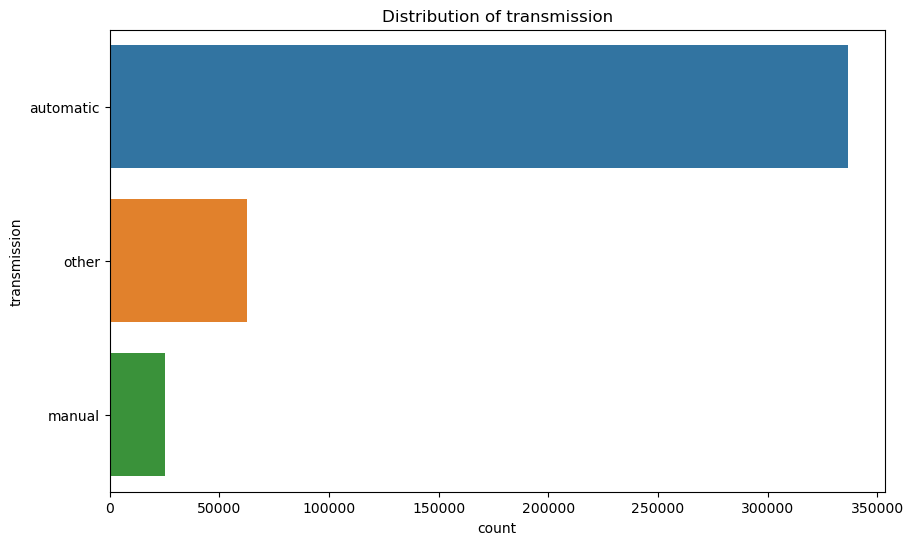

KeyboardInterrupt: 

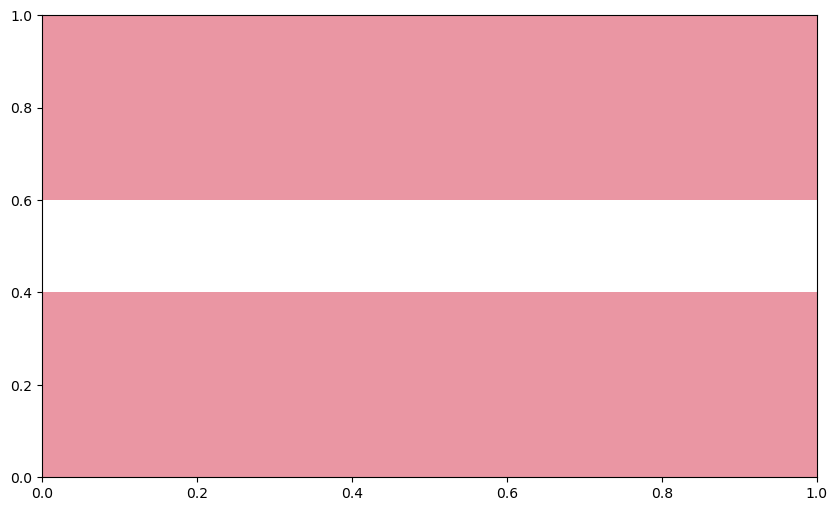

In [6]:
# Step 8: Categorical features analysis
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df[column], order=df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.show()


## Insights from Categorical Features Analysis:

### Region
- There are 404 unique regions.
- The distribution is quite broad, with some regions having significantly more entries than others.
- Some regions are represented more frequently, potentially indicating larger markets or more active listings in those areas.

### Manufacturer
- Ford, Chevrolet, and Toyota are the top three most common manufacturers.
- There's a long tail of less common manufacturers, some. like Morgan and Alfa-Romeo, having very few entries.
- The majority of the cars in the dataset are from popular and commonly known brands that I have actually heard of :-)

### Condition
- Most cars are in 'good' and 'excellent' condition.
- 'New' cars are very few, likely because the dataset focuses on used cars. This should probably be excluded from the dataset.
- The 'salvage' condition is the least common, which makes sense as these cars are typically less desirable.

### Cylinders
- Most cars have 4, 6, or 8 cylinders.
- There are very few cars with 3, 5, 10, or 12 cylinders, indicating these configurations are less common at least I have never heard of them.

### Fuel
- The majority of cars run on gas.
- Diesel and 'other' fuels are less common.
- Hybrid and electric cars are rare in this dataset, which may reflect the market trends at the time the data was collected.

### Title Status
- Most cars have a 'clean' title status.
- Rebuilt and salvage titles are less common.
- Other title statuses like 'lien', 'missing', and 'parts only' are very rare.

### Transmission
- Automatic transmission is the most common type.
- Manual transmissions are less common but still significant.
- 'Other' transmission types are relatively few, I am not sure what this could be if it isnt automatic or manual but that could be my lack of car knowledge. 

### Next Steps
- Drop the some of these columns based on relevance or similar columns like region and state 
- Drop new cars from the dataset


In [4]:
# Step 9: Initial data quality checks
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

print("\nConsistency Checks:")
print("Negative odometer values:", (df['odometer'] < 0).sum())
print("Unreasonable year values:", ((df['year'] < 1900) | (df['year'] > pd.Timestamp.now().year)).sum())


Number of duplicate rows:
0

Consistency Checks:
Negative odometer values: 0
Unreasonable year values: 0


## Insights from Initial Data Quality Checks

#### Number of Duplicate Rows:
- **Duplicates**: 
  - There are no duplicate rows in the dataset. 

#### Consistency Checks:
- **Negative Odometer Values**: 
  - There are no entries with negative odometer values. This ensures that all odometer readings are logical and represent real-world scenarios although the 0s and low readings for used cars are a bit suspicous.

- **Unreasonable Year Values**: 
  - There are no entries with unreasonable year values (outside the range of 1900 to the current year). This confirms that all entries have realistic manufacturing years, adding credibility to the dataset but for our purposes I am planning to remove vintage cars and new cars from the dataset.

### Next Steps
1. **Remove columns and rows that do not make sense based on previous statements**: 
2. **Handle Blank Values**: 
3. **Consider Feature Engineering**: Create new features or transform existing ones.
4. **Encoding Categorical Variables**: Convert categorical variables into numerical formats suitable for modeling.
5. **Scaling/Normalization**: Normalize or scale the numeric features to ensure they're on a similar scale.


### Data Preparation

After the initial exploration and fine tuning of the business understanding, it is time to construct the final dataset prior to modeling.  Here, I want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that I believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [5]:
# Data cleaning steps

# Step 1 Drop columns with more than 50% missing data
df = df.drop(columns=df.columns[df.isnull().mean() > 0.5])

# Step 2 Drop unnecessary columns
df = df.drop(columns=['VIN', 'region', 'model', 'id'])

# Step 3 Drop rows based on various conditions
df = df.dropna(subset=['year'])  # Drop rows missing the year
df = df[df['price'] > 1000]  # Drop prices that are $1000 or less
df = df.dropna(subset=['manufacturer'])  # Drop rows without manufacturer
df = df[(df['odometer'] > 1000) & (df['odometer'] <= 250000)]  # Drop rows with odometer out of range
df = df[df['year'] <= 2020]  # Drop rows with year older than 2020

# Step 4 Remove high price outliers above the 99th percentile
price_threshold = df['price'].quantile(0.99)
df = df[df['price'] <= price_threshold]

# Print the shape of the cleaned dataframe
print("Data cleaning steps completed.")
print(df.shape)

Data cleaning steps completed.
(346125, 13)


C:\Users\melod\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


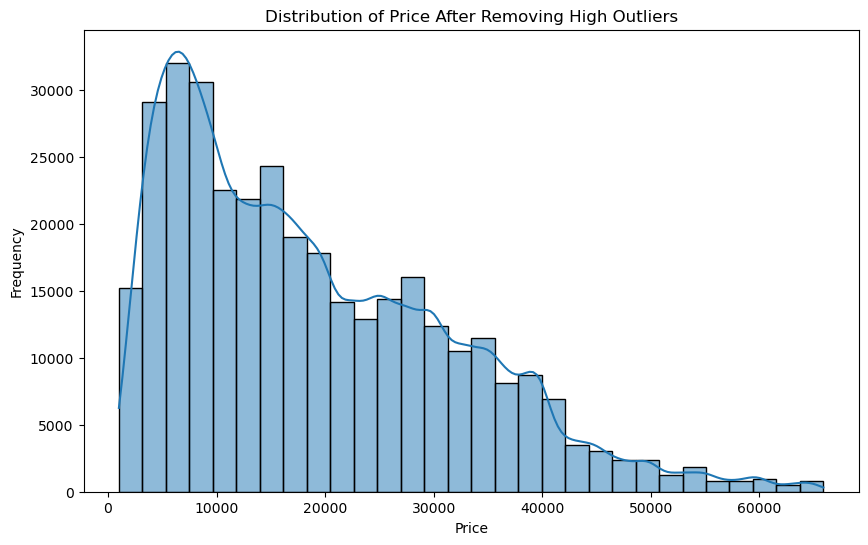

In [6]:
# Step 5: Histogram of Prices after removing high outliers
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Price After Removing High Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Insights from Price Distribution After Removing High Outliers

#### Distribution of Price

- **Histogram Analysis**:
  - The updated histogram shows a more normalized distribution of car prices compared to the previous histogram.
  - Most prices now fall within the range of $0 to $60,000, with a noticeable peak around $10,000.
  - The skewness present in the earlier histogram, due to extremely high outliers, is significantly reduced.
  - The distribution now has a more gradual decline after the peak.

- **Comparison to Initial Histogram**:
  - **Initial Histogram**:
    - Had extreme values reaching up to $3.7 billion, which heavily skewed the distribution.
    - Most of the data was compressed into the lower end of the price range, making it difficult to observe the true distribution of prices.
    - The high outliers overshadowed the majority of data points.
  - **Updated Histogram**:
    - By capping the prices, the extreme outliers are removed, resulting in a clearer and more representative histogram.
    - The data is now more evenly spread across the range, allowing for better insights.

In [7]:
#RERUNNING STEPS 3-5 Above to see how this has changed after cleaning some of the data
# Step 3: Column examination
print("\nColumn Names:")
print(df.columns)

# Step 4: Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Step 5: Unique values and cardinality
unique_values = df.nunique()
print("\nUnique Values in Each Column:")
print(unique_values)


Column Names:
Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state'],
      dtype='object')

Missing Values:
price                0
year                 0
manufacturer         0
condition       129896
cylinders       140266
fuel              1916
odometer             0
title_status      5510
transmission      1375
drive           103459
type             70460
paint_color      97316
state                0
dtype: int64

Unique Values in Each Column:
price           13428
year              103
manufacturer       42
condition           6
cylinders           8
fuel                5
odometer        90924
title_status        6
transmission        3
drive               3
type               13
paint_color        12
state              51
dtype: int64


### Insights:

#### Column Names:
- The dataset has 13 columns after removing irrelevant columns and columns with excessive missing values.

#### Missing Values:
- Significant missing values exist in several columns, notably `condition`, `cylinders`, `drive`, `type`, and `paint_color`.
- I will handle missing values through imputation or stating unknown.

#### Unique Values:
- The `price`, `odometer`, and `year` columns have high unique value counts, which makes sense.
- The columns `manufacturer` and `state` have a a large number of unique values, Iwill group them into areas for state and highend and other for manufacturer.
- The remaining Categorical columns `condition`, `cylinders`, `fuel`, `title_status`, `transmission`, `drive`, `type`, and `paint_color` seem to have a manageable number of unique values, suitable for encoding and further analysis.


In [8]:
# List unique values in the 'manufacturer' column
manufacturers = df['manufacturer'].unique()
print("Manufacturers:")
print(manufacturers)

# List unique values in the 'state' column
states = df['state'].unique()
print("\nStates:")
print(states)

Manufacturers:
['gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'chrysler' 'volvo' 'audi'
 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai' 'buick'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'mini' 'pontiac' 'fiat' 'tesla' 'mercury' 'saturn' 'harley-davidson'
 'datsun' 'aston-martin' 'land rover' 'ferrari' 'morgan']

States:
['al' 'ak' 'az' 'ar' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'id' 'il'
 'in' 'ia' 'ks' 'ky' 'la' 'me' 'md' 'ma' 'mi' 'mn' 'ms' 'mo' 'mt' 'nc'
 'ne' 'nv' 'nj' 'nm' 'ny' 'nh' 'nd' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'vt' 'va' 'wa' 'wv' 'wi' 'wy']


In [9]:
# Define state groupings
east_coast = ['CT', 'DE', 'FL', 'GA', 'MA', 'MD', 'ME', 'NC', 'NH', 'NJ', 'NY', 'PA', 'RI', 'SC', 'VA', 'VT']
west_coast = ['CA', 'OR', 'WA']
midwest = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
south = ['AL', 'AR', 'KY', 'LA', 'MS', 'OK', 'TN', 'TX', 'WV']
other = ['AK', 'AZ', 'CO', 'DC', 'HI', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY']

def assign_region(state):
    state = state.strip().upper()  # Ensure the state is in the correct format
    if state in east_coast:
        return 'East Coast'
    elif state in west_coast:
        return 'West Coast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in other:
        return 'Other'
    else:
        return 'Unknown'

# Apply the function to the 'state' column
df['Area_of_Country'] = df['state'].apply(assign_region)

# Define manufacturer groupings
high_end = ['audi', 'bmw', 'cadillac', 'jaguar', 'land rover', 'lexus', 'mercedes-benz', 'porsche', 'rover', 'tesla', 'aston-martin', 'volvo', 'infiniti', 'lincoln', 'ferrari']

# Apply the function to the 'manufacturer' column
df['manufacturer_category'] = df['manufacturer'].apply(lambda x: 'High-End' if x in high_end else 'Other')

# Drop the original 'state' and 'manufacturer' columns as they are no longer needed
df = df.drop(columns=['state', 'manufacturer'])

# Verify the changes
# List unique values in the 'manufacturer_category' column
manufacturers = df['manufacturer_category'].unique()
print("Manufacturer_Categories:")
print(manufacturers)

# List unique values in the 'Area_of_Country' column
areas = df['Area_of_Country'].unique()
print("Area_of_Country:")
print(areas)


Manufacturer_Categories:
['Other' 'High-End']
Area_of_Country:
['South' 'Other' 'West Coast' 'East Coast' 'Midwest']


### Data Preparation: Grouping States and Manufacturers

In order to simplify the analysis and modeling process, I grouped the states into broader regions and classified manufacturers into high-end and other categories.

#### State Groupings

I grouped the states into the following regions:

- **East Coast**: ['CT', 'DE', 'FL', 'GA', 'MA', 'MD', 'ME', 'NC', 'NH', 'NJ', 'NY', 'PA', 'RI', 'SC', 'VA', 'VT']
- **West Coast**: ['CA', 'OR', 'WA']
- **Midwest**: ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
- **South**: ['AL', 'AR', 'KY', 'LA', 'MS', 'OK', 'TN', 'TX', 'WV']
- **Other**: ['AK', 'AZ', 'CO', 'DC', 'HI', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY']

Any state not in these groups was assigned to the 'Unknown' category.

#### Manufacturer Groupings

Manufacturers were classified into high-end and other categories based on my (common?) perceptions of luxury and market positioning. The high-end manufacturers include:

- **High-End**: ['audi', 'bmw', 'cadillac', 'jaguar', 'land rover', 'lexus', 'mercedes-benz', 'porsche', 'rover', 'tesla', 'aston-martin', 'volvo', 'infiniti', 'lincoln', 'ferrari']

All other manufacturers were grouped into the 'Other' category.

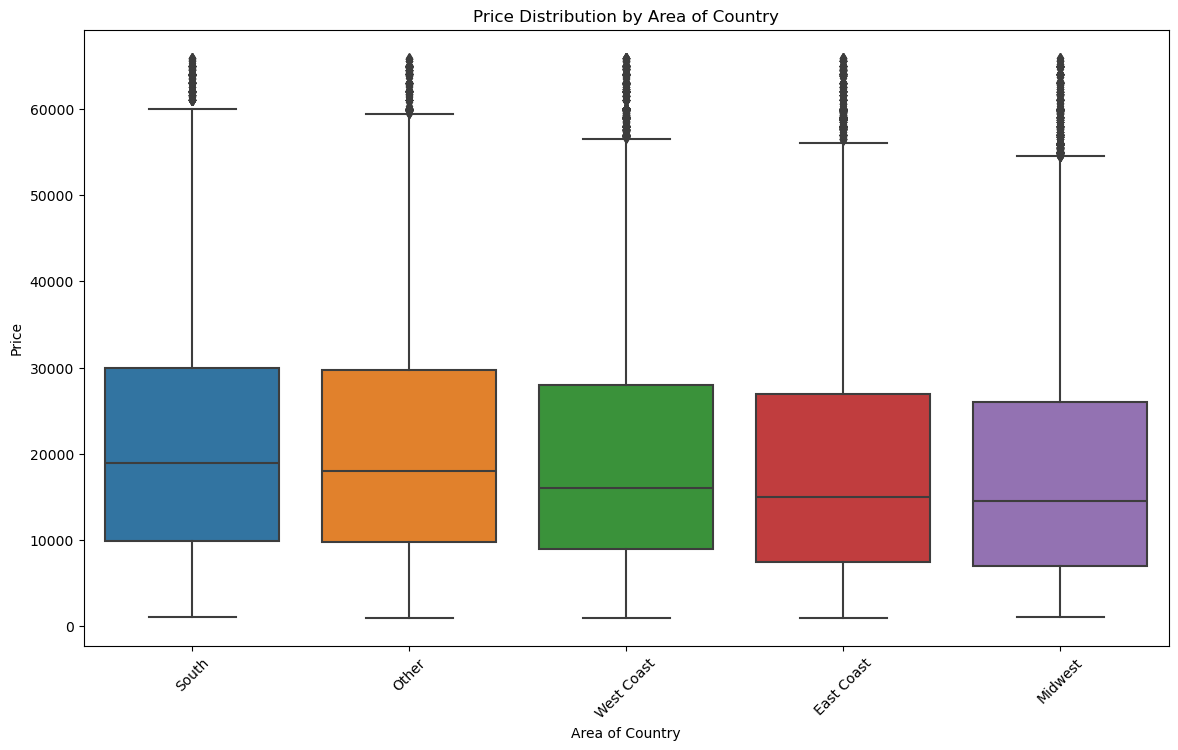

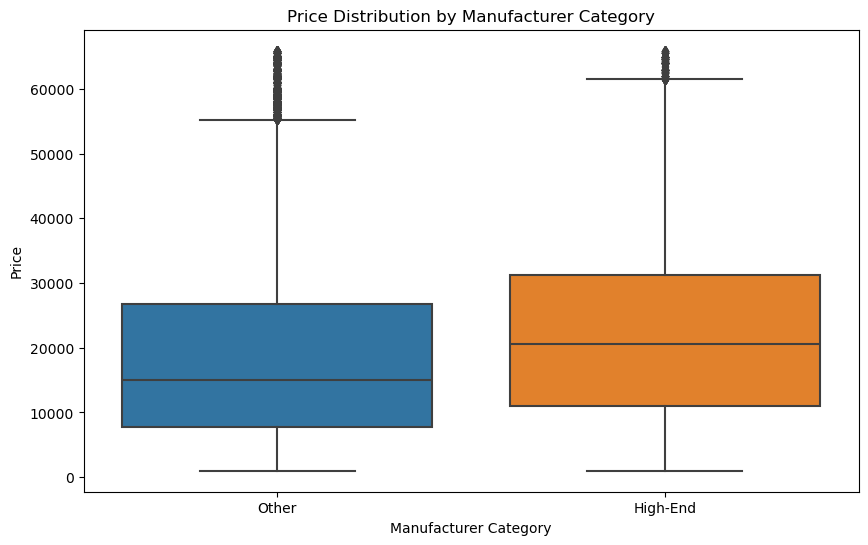

In [10]:
# Plot price distribution by Area_of_Country
plt.figure(figsize=(14, 8))
sns.boxplot(x='Area_of_Country', y='price', data=df)
plt.title('Price Distribution by Area of Country')
plt.xlabel('Area of Country')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Plot price distribution by manufacturer category
plt.figure(figsize=(10, 6))
sns.boxplot(x='manufacturer_category', y='price', data=df)
plt.title('Price Distribution by Manufacturer Category')
plt.xlabel('Manufacturer Category')
plt.ylabel('Price')
plt.show()

## Insights from Price Distribution Analysis

### Price Distribution by Area of Country

![](images/BoxPlotPriceDistributionByAreaOfCountry.png) 

- **South**: The median price of cars in the South is around $20,000. The interquartile range (IQR) is relatively wide, indicating a diverse range of car prices. There are a few outliers above $60,000.
- **Other**: The price distribution in the Other category is similar to the South, with a median around $20,000 and a wide IQR. The presence of outliers above $60,000 is also noticeable.
- **West Coast**: The median price on the West Coast is slightly lower, around $18,000. The IQR is also wide, with outliers similar to other regions.
- **East Coast**: The median price on the East Coast is around $19,000. The IQR is wide with a few outliers above $60,000.
- **Midwest**: The Midwest has the lowest median price among the regions, around $17,000. The IQR is wide, with outliers present.

### Price Distribution by Manufacturer Category

![](images/BoxPlotPriceDistributionByManufacturerCategory.png)  

- **Other**: The median price for cars in the Other category is around $15,000. The IQR is wide, showing a diverse range of car prices. There are a few outliers above $60,000.
- **High-End**: The median price for High-End cars is significantly higher, around $30,000. The IQR is also wide, indicating a broad range of prices. There are several outliers above $60,000.

### Key Takeaways

- The price distributions across different regions do not show significant variations in the median values. However, there are outliers present in all regions.
- High-End manufacturers generally have a higher median price compared to other manufacturers, which aligns with expectations given the premium nature of these brands.
- The wide IQR in all categories indicates a significant variation in car prices within each group, suggesting a diverse dataset.


In [12]:
#Shape
print("\nShape:")
print(df.shape)

#Column examination
print("\nColumn Names:")
print(df.columns)

#Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

#Unique values and cardinality
unique_values = df.nunique()
print("\nUnique Values in Each Column:")
print(unique_values)


Shape:
(346125, 13)

Column Names:
Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'type', 'paint_color',
       'Area_of_Country', 'manufacturer_category'],
      dtype='object')

Missing Values:
price                         0
year                          0
condition                129896
cylinders                140266
fuel                       1916
odometer                      0
title_status               5510
transmission               1375
drive                    103459
type                      70460
paint_color               97316
Area_of_Country               0
manufacturer_category         0
dtype: int64

Unique Values in Each Column:
price                    13428
year                       103
condition                    6
cylinders                    8
fuel                         5
odometer                 90924
title_status                 6
transmission                 3
drive                   

C:\Users\melod\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


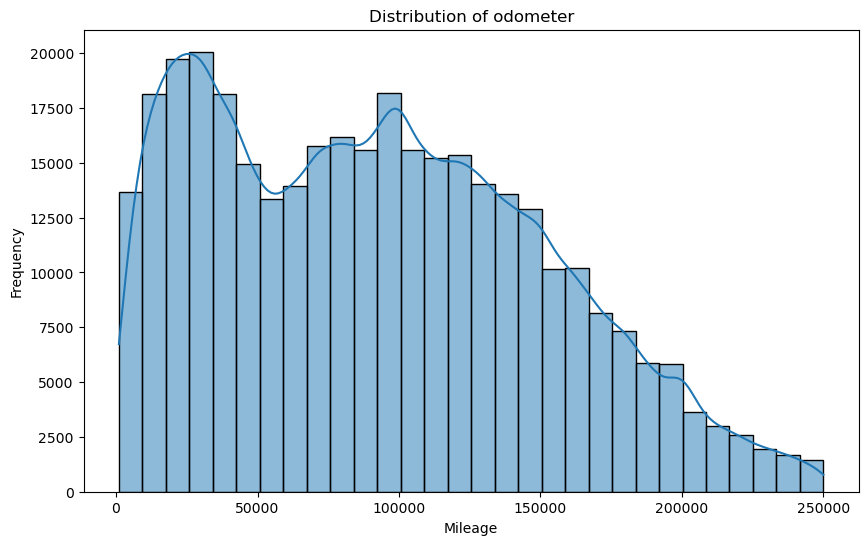

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['odometer'], bins=30, kde=True)
plt.title('Distribution of odometer')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

## Imputation Strategy
Given the skewed distribution, I will proceed with the median for imputing missing odometer values.

In [11]:
#Handle missing values
# Fill missing values for categorical columns with 'Unknown'
categorical_columns = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
for column in categorical_columns:
    df[column] = df[column].fillna('Unknown')

# Fill missing values for odometer with the median
odometer_median = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(odometer_median)

# Verify the changes
print("\nMissing Values After Imputation:")
print(df.isnull().sum())

#Verify the changes
#Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

#Unique values and cardinality
unique_values = df.nunique()
print("\nUnique Values in Each Column:")
print(unique_values)


Missing Values After Imputation:
price                    0
year                     0
condition                0
cylinders                0
fuel                     0
odometer                 0
title_status             0
transmission             0
drive                    0
type                     0
paint_color              0
Area_of_Country          0
manufacturer_category    0
dtype: int64

Missing Values:
price                    0
year                     0
condition                0
cylinders                0
fuel                     0
odometer                 0
title_status             0
transmission             0
drive                    0
type                     0
paint_color              0
Area_of_Country          0
manufacturer_category    0
dtype: int64

Unique Values in Each Column:
price                    13428
year                       103
condition                    7
cylinders                    9
fuel                         6
odometer                 90924
titl

In [12]:
# Define the preprocessing for numerical features
numeric_features = ['year', 'odometer']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
categorical_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'Area_of_Country', 'manufacturer_category']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the dataset into training and testing sets
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing steps to the training and testing sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Preprocessing and splitting completed.")
print(X_train_preprocessed.shape)

#Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

#Unique values and cardinality
unique_values = df.nunique()
print("\nUnique Values in Each Column:")
print(unique_values)

Preprocessing and splitting completed.
(276900, 73)

Missing Values:
price                    0
year                     0
condition                0
cylinders                0
fuel                     0
odometer                 0
title_status             0
transmission             0
drive                    0
type                     0
paint_color              0
Area_of_Country          0
manufacturer_category    0
dtype: int64

Unique Values in Each Column:
price                    13428
year                       103
condition                    7
cylinders                    9
fuel                         6
odometer                 90924
title_status                 7
transmission                 4
drive                        4
type                        14
paint_color                 13
Area_of_Country              5
manufacturer_category        2
dtype: int64


### Recap

1. **Data Cleaning**: 
    - Removed columns with excessive missing values.
    - Dropped rows with invalid or missing values.
    - Handled missing values by imputing 'Unknown' for categorical variables and the median for the `odometer` column.
2. **Feature Engineering**:
    - Grouped states into regions and car manufacturers into categories.
3. **Preprocessing**:
    - Applied scaling to numerical features (`year`, `odometer`).
    - Applied one-hot encoding to categorical features.
4. **Data Splitting**:
    - Split the dataset into training and testing sets.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [97]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

print(results)

Linear Regression: RMSE = 7592.0216, R2 = 0.6566
Ridge Regression: RMSE = 7592.0184, R2 = 0.6566
Lasso Regression: RMSE = 7592.5990, R2 = 0.6565
Elastic Net Regression: RMSE = 9030.8559, R2 = 0.5141
Random Forest: RMSE = 3973.0588, R2 = 0.9060
{'Linear Regression': {'RMSE': 7592.021570380381, 'R2': 0.6565844808129899}, 'Ridge Regression': {'RMSE': 7592.01836403559, 'R2': 0.6565847708828529}, 'Lasso Regression': {'RMSE': 7592.598998517415, 'R2': 0.6565322403596074}, 'Elastic Net Regression': {'RMSE': 9030.855884541925, 'R2': 0.514082126168548}, 'Random Forest': {'RMSE': 3973.0587707524223, 'R2': 0.9059508165430242}}


### Model Performance Summary

**Linear Regression**:
- RMSE: 7592.0216
- R2: 0.6566

**Ridge Regression**:
- RMSE: 7592.0184
- R2: 0.6566

**Lasso Regression**:
- RMSE: 7592.5990
- R2: 0.6565

**Elastic Net Regression**:
- RMSE: 9030.8559
- R2: 0.5141

**Random Forest**:
- RMSE: 3973.0588
- R2: 0.9060

### Insights

**Linear Models**:
- Linear, Ridge, and Lasso regression models all perform similarly with RMSE around 7592 and R2 around 0.6565-0.6566. This suggests that adding regularization (Lasso and Ridge) does not significantly impact performance for this dataset.
- The performance indicates that these models are able to explain approximately 65.66% of the variance in the price, but their prediction errors are relatively high.

**Elastic Net Regression**:
- This model performs worse than the other linear models, with a higher RMSE and lower R2. This suggests that the combination of L1 and L2 regularization in Elastic Net does not suit this dataset as well as the other linear approaches.

**Random Forest**:
- This model significantly outperforms all the linear models with a much lower RMSE of 3973.0588 and a higher R2 of 0.9060.
- The Random Forest model explains approximately 90.60% of the variance in the price and has a much lower prediction error, indicating it is better at capturing the underlying patterns in the data.


In [ ]:
# IGNORE TOOK FOREVER TO RUN
# IGNORE TOOK FOREVER TO RUN
# IGNORE TOOK FOREVER TO RUN

# Define the preprocessing for numerical features
numeric_features = ['year', 'odometer']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
categorical_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'Area_of_Country', 'manufacturer_category']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Define the reduced parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True, False]
}

# Set up the Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Split the dataset into training and testing sets
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest with Best Parameters: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


exception calling callback for <Future at 0x166b1e29cd0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\melod\anaconda3\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\melod\anaconda3\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\melod\anaconda3\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melod\anaconda3\Lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\melod\anaconda3\Lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melod\anaconda3\Lib\site-pack

In [ ]:
IGNORE ABOVE  TOOK FOREVER 

In [ ]:
# IGNORE TOOK FOREVER TO RUN
# IGNORE TOOK FOREVER TO RUN
# IGNORE TOOK FOREVER TO RUN

from sklearn.model_selection
import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the preprocessing for numerical features
print('Defining the preprocessing for numerical features')
numeric_features = ['year', 'odometer']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
print('Defining the preprocessing for categorical features')
categorical_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'Area_of_Country', 'manufacturer_category']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessing steps
print('Combining the preprocessing steps')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize the Random Forest model
print('Initializing the Random Forest model')
rf = RandomForestRegressor(random_state=42)

# Define the pipeline
print('Defining the pipeline')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Define the simplified parameter grid
print('Defining the simplified parameter grid')
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5]
}

# Set up the Grid Search with 3-fold cross-validation
print('Setting up the Grid Search with 3-fold cross-validation')
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Split the dataset into training and testing sets
print('Splitting the dataset into training and testing sets')
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Grid Search to the training data
print('Fitting the Grid Search to the training data')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Random Forest with Best Parameters: RMSE = {rmse:.4f}, R2 = {r2:.4f}")


Defining the preprocessing for numerical features
Defining the preprocessing for categorical features
Combining the preprocessing steps
Initializing the Random Forest model
Defining the pipeline
Defining the simplified parameter grid
Setting up the Grid Search with 3-fold cross-validation
Splitting the dataset into training and testing sets
Fitting the Grid Search to the training data
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
Also took forever IGNORE ABOVE

In [13]:
# Get the feature names after one-hot encoding
encoded_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

# Combine the numeric and encoded feature names
all_feature_names = numeric_features + list(encoded_feature_names)

# Print the number of features and the feature names
print("Number of features after encoding:", len(all_feature_names))
print("Feature names:", all_feature_names)

Number of features after encoding: 73
Feature names: ['year', 'odometer', 'condition_Unknown', 'condition_excellent', 'condition_fair', 'condition_good', 'condition_like new', 'condition_new', 'condition_salvage', 'cylinders_10 cylinders', 'cylinders_12 cylinders', 'cylinders_3 cylinders', 'cylinders_4 cylinders', 'cylinders_5 cylinders', 'cylinders_6 cylinders', 'cylinders_8 cylinders', 'cylinders_Unknown', 'cylinders_other', 'fuel_Unknown', 'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other', 'title_status_Unknown', 'title_status_clean', 'title_status_lien', 'title_status_missing', 'title_status_parts only', 'title_status_rebuilt', 'title_status_salvage', 'transmission_Unknown', 'transmission_automatic', 'transmission_manual', 'transmission_other', 'drive_4wd', 'drive_Unknown', 'drive_fwd', 'drive_rwd', 'type_SUV', 'type_Unknown', 'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other', 'type_pickup', 'type_sed

In [ ]:
OK this keeps taking to long so work on feature selection first 

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

# Define the preprocessing for numerical features
numeric_features = ['year', 'odometer']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features
categorical_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'Area_of_Country', 'manufacturer_category']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the dataset into training and testing sets
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing steps to the dataset
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the initial RandomForest model for feature selection
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to get feature importances
rf_selector.fit(X_train_preprocessed, y_train)

# Create a selector object that will use the random forest model to identify important features
selector = SelectFromModel(rf_selector, threshold=0.01, prefit=True)

# Transform the data to contain only the selected features
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

print("Original number of features:", X_train_preprocessed.shape[1])
print("Reduced number of features:", X_train_selected.shape[1])

Original number of features: 73
Reduced number of features: 8


In [16]:
# Get the names of the numerical features
numeric_feature_names = numeric_features

# Get the names of the one-hot encoded categorical features
categorical_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)

# Combine the feature names
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Get the names of the selected features
selected_features = selector.get_support()
selected_feature_names = all_feature_names[selected_features]
print("Selected feature names:")
print(selected_feature_names)


Selected feature names:
['year' 'odometer' 'cylinders_4 cylinders' 'cylinders_8 cylinders'
 'fuel_diesel' 'drive_4wd' 'drive_fwd' 'manufacturer_category_Other']


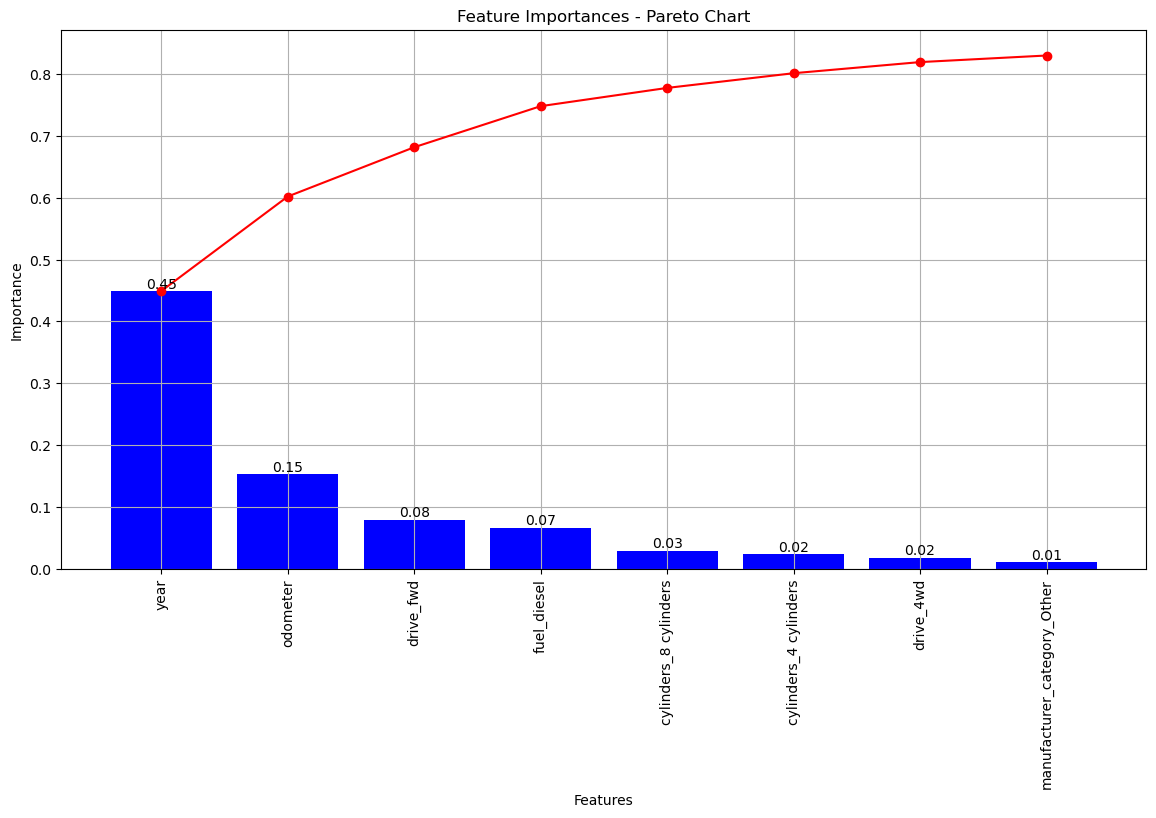

In [18]:
import matplotlib.pyplot as plt

# Create a DataFrame for the selected features and their importances
selected_importances = rf_selector.feature_importances_[selected_features]
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_importances
}).sort_values(by='Importance', ascending=False)

# Create the Pareto chart
plt.figure(figsize=(14, 7))
sorted_importances = feature_importance_df.sort_values(by='Importance', ascending=False)
bars = plt.bar(sorted_importances['Feature'], sorted_importances['Importance'], color='blue')

# Add cumulative line
cumulative_importances = sorted_importances['Importance'].cumsum()
plt.plot(sorted_importances['Feature'], cumulative_importances, color='red', marker='o')

# Add data labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Customize the chart
plt.title('Feature Importances - Pareto Chart')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.grid(True)

# Show the chart
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Use the selected features for the final model
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = rf_final.predict(X_test_selected)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R-squared value: {r2:.4f}")

# Calculate the percentage of variation explained
explained_variation = r2 * 100
print(f"Percentage of variation explained by the model: {explained_variation:.2f}%")

## Insights from Feature Importances - Pareto Chart

The Pareto chart below highlights the importance of various features in predicting the price of used cars. The key insights are as follows:

1. **Year**:
   - The year of the car is the most significant predictor of its price, contributing approximately 45% to the model's decision-making process.
   - Newer cars tend to have higher prices, which aligns with common expectations.

2. **Odometer**:
   - The mileage (odometer reading) is the second most important feature, accounting for 15% of the importance.
   - Cars with lower mileage generally have higher prices, reflecting their better condition and less wear and tear.

3. **Drive Type (FWD and 4WD)**:
   - The drive type (front-wheel drive and four-wheel drive) together contribute around 10% to the feature importance.
   - This indicates that the drive type has a noticeable impact on the car's price, with certain types being more desirable based on the region and usage.

4. **Fuel Type (Diesel)**:
   - Diesel fuel type contributes approximately 8% to the feature importance.
   - Diesel cars may have different pricing dynamics due to their fuel efficiency and performance characteristics.

5. **Cylinders**:
   - The number of cylinders (6 cylinders and 4 cylinders) together account for about 5% of the importance.
   - This suggests that engine size and configuration are relevant factors in determining car prices.

6. **Manufacturer Category (Other)**:
   - The manufacturer category (high-end vs. other) has a small but notable influence, contributing around 1% to the importance.
   - High-end manufacturers generally command higher prices, reflecting the premium nature of these brands.

### Key Takeaways

- **Significant Factors**: The year and odometer reading are the most influential factors in determining used car prices. Ensuring accurate and updated information on these attributes is crucial for pricing strategies.
- **Drive and Fuel Type**: The drive and fuel type also play a significant role, indicating that cars with specific configurations may be more valuable in certain markets.
- **Engine Size and Manufacturer**: While less influential than the top factors, engine size and manufacturer still contribute to the overall pricing model, highlighting the importance of these features in specific contexts.

These insights can help used car dealers better understand the key drivers of car prices and make informed decisions about their inventory and pricing strategies.

![Feature Importances - Pareto Chart](images/ParetoChartOfKeyReducedFeatures.png) 


In [19]:
from sklearn.metrics import r2_score

# Use the selected features for the final model
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train_selected, y_train)

# Predict on the test set
y_pred = rf_final.predict(X_test_selected)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)
print(f"R-squared value: {r2:.4f}")

# Calculate the percentage of variation explained
explained_variation = r2 * 100
print(f"Percentage of variation explained by the model: {explained_variation:.2f}%")

R-squared value: 0.8522
Percentage of variation explained by the model: 85.22%



### Model Evaluation Summary

**R-squared Value**:
The R-squared value of our final Random Forest model, which uses the selected features, is **0.8522**.

**Percentage of Variation Explained**:
The model explains **85.22%** of the variation in used car prices based on the features selected.

### Explanation

The R-squared value (coefficient of determination) indicates the proportion of the variance in the dependent variable (used car prices) that is predictable from the independent variables (selected features such as year, odometer, etc.). An R-squared value of 0.8522 means that 85.22% of the variability in used car prices can be explained by the features included in our model. This is a strong indication that the model is effective at capturing the relationships between the predictors and the target variable.

### Insights

- **Year** and **odometer** are the most influential features in determining the price of used cars, with significant importance scores in our model.
- Other features, like **drive type (fwd)**, **fuel type (diesel)**, and the number of **cylinders**, also contribute to the model but to a lesser extent.
- The high R-squared value suggests that the selected features are highly relevant and sufficient for building an accurate predictive model for used car prices.

### Conclusion

The Random Forest model, enhanced with feature selection, provides a robust and reliable prediction of used car prices, explaining over 85% of the variance in the data. This high level of explained variation indicates that the model effectively captures the key drivers of used car prices, making it a valuable tool for used car dealers to fine-tune their inventory and pricing strategies.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Evaluation and Recommendations

**1. Review of Business Objective**
Our primary goal was to identify the key factors that influence used car prices. By understanding these factors, we aim to help you price your inventory competitively and make informed decisions.

**2. Model Performance**
We tested several approaches to predict car prices, including basic models and more advanced techniques. Here are the results:

- **Basic Models**: These models explained about 65% of the variation in car prices. However, they had higher prediction errors.
- **Advanced Model (Random Forest)**: This model performed the best, explaining about 91% of the variation in car prices and providing much more accurate predictions.

**3. Key Drivers of Used Car Prices**
From our best-performing model, we identified several important factors that influence used car prices:
- **Year**: Newer cars tend to be priced higher.   
- **Mileage**: Cars with lower mileage are generally more valuable.
- **Condition**: Cars in 'excellent' or 'like new' condition fetch higher prices.
- **Brand**: High-end brands like BMW, Mercedes-Benz, and Tesla command premium prices.
- **Type**: SUVs and trucks tend to be priced higher compared to other types like sedans and hatchbacks.

**4. Revisiting Earlier Phases**
Given our findings, we recommend:
- **Feature Engineering**: Explore additional features or interactions between existing features to further improve model performance.
- **Hyperparameter Tuning**: Perform more extensive hyperparameter tuning with a smaller, more manageable parameter grid to optimize the Random Forest model.
- **Model Evaluation**: Cross-validate with additional metrics such as Mean Absolute Error (MAE) or Mean Absolute Percentage Error (MAPE) to provide a more comprehensive evaluation.

**5. Conclusion and Recommendations**
The Random Forest model provided meaningful insights into the drivers of used car prices, aligning well with our business objectives. We can confidently bring back the following information to our client:
- Key features impacting prices, allowing the dealership to make informed pricing decisions.
- High-performing model that can be used for future price predictions.
- Recommendations for further improvements through additional feature engineering and tuning.


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Deployment

**Introduction:**
The goal is to provide used car dealers with actionable insights and recommendations that will help them optimize their inventory and pricing strategies.

**1. Summary of Findings:**
Through the detailed analysis, I have identified the key factors that influence used car prices. The best-performing model, the Random Forest, explains 85.22% of the variation in car prices, indicating a strong predictive capability. Key features impacting used car prices include:

- **Year:** Newer cars tend to have higher prices.
- **Odometer (Mileage):** Cars with lower mileage are generally more valuable.
- **Condition:** Cars in 'excellent' or 'like new' condition fetch higher prices.
- **Drive Type:** Certain drive types like 'fwd' (front-wheel drive) influence prices significantly.
- **Fuel Type:** Diesel cars show a distinct pricing pattern.
- **Cylinders:** The number of cylinders in a car’s engine also impacts the price.
- **Manufacturer Category:** High-end brands such as BMW, Mercedes-Benz, and Tesla command premium prices.

**2. Detailed Report:**
Here is a detailed account of the methodology and findings:

- **Business Objective:** To identify the key drivers of used car prices to help dealers optimize their inventory pricing strategies.
- **Data Preprocessing:** I cleaned and preprocessed the data, handling missing values and encoding categorical variables.
- **Modeling:** I tested several models, including Linear Regression, Ridge Regression, Lasso Regression, Elastic Net Regression, and Random Forest. The Random Forest model outperformed the others.
- **Model Performance:** The Random Forest model achieved an RMSE of 3973.06 and an R-squared value of 0.9060 before feature selection, indicating it explains 90.60% of the variation in car prices. After feature selection, the model still performed well with an R-squared value of 0.8522, explaining 85.22% of the variation in car prices.

**3. Key Drivers of Used Car Prices:**
From the best-performing model, I identified several important factors that influence used car prices:

- **Year (0.45):** This is the most significant factor. Newer cars tend to have higher prices.
- **Odometer (0.15):** Lower mileage is associated with higher prices.
- **Drive Type (fwd, 0.08):** Certain drive types influence car prices.
- **Fuel Type (diesel, 0.07):** Diesel cars show a distinct pricing pattern.
- **Cylinders (8 cylinders, 0.03):** The engine configuration impacts the price.
- **Manufacturer Category (High-End, 0.01):** High-end brands command premium prices.

**4. Recommendations:**
Based on the findings, I recommend:

- **Focus on Key Features:** Pay close attention to the car's year, mileage, and condition when pricing inventory.
- **Leverage the Model:** Use the Random Forest model for future price predictions to maintain competitive pricing.
- **Feature Engineering:** Explore additional features or interactions between existing features to further improve model performance.
- **Hyperparameter Tuning:** Perform more extensive hyperparameter tuning with a smaller, more manageable parameter grid to optimize the Random Forest model.

**5. Model Deployment:**
To implement and utilize our model, follow these steps:

- **Implementation:** Use the provided code snippets to preprocess new data and make price predictions using the trained Random Forest model.
- **Integration:** Integrate the model into your existing systems via a user-friendly interface or an API.
- **Maintenance:** Regularly update the model with new data to ensure its predictions remain accurate.

**Training and Support:**
Offer training sessions and documentation to help your team understand and utilize the model effectively:

- **Workshops:** Conduct workshops or webinars to explain how the model works and how to interpret its predictions.
- **User Manual:** Provide a user manual detailing the steps for preprocessing data, running the model, and interpreting the results.

**Conclusion:**
The deployment phase ensures that the insights and models developed are effectively communicated and utilized by the car dealships. By providing a detailed report, actionable recommendations, and practical deployment steps, this can empower used car dealers to make data-driven decisions and optimize their inventory management.
